In [136]:
import matplotlib.pyplot as plt
import math

In [137]:
CPU_AVERAGE_CLOCK = 3.208 * 10**9  # 60**9, 6
PHU_MIN_CLOCK = 10 * 10**9  # 100**9, 10 Ghz
PHU_MULTIPLEX = 20
PHU_CORES = 1

In [141]:
class matmul_stats:
    def __init__(self, input):
        self.input = input
        self.num_dot = input[0][0] * input[1][-1]
        self.len_dot = input[0][-1]
        self.num_mac = self.num_dot * self.len_dot
        self.total_data = (self.input[0][0] *  self.input[0][1]) + (self.input[1][0] *  self.input[1][1]) + self.num_dot
        self.arithmatic_intensity = self.num_mac / self.total_data
        self.e_cost_t = cpu_matmul_time(self.num_mac)
        self.p_cost_t = phu_matmul_time(self.num_dot, self.len_dot)
        self.p_detail_cost_t = phu_matmul_time_detailed(self.input)

def get_matmul_info(sl):
    m_in = [[sl, 4096], [4096, 4096]]
    # m_in = [sl,128],[128, sl]
    return  matmul_stats(m_in)

def cpu_matmul_time(num_mac):
    m = 6.845684637179875e-11
    b = 8.258292187675319e-07

    time = (m * num_mac) + b
    return time * CPU_AVERAGE_CLOCK

def phu_matmul_time(num_dot, len_dot):
    return math.ceil(math.ceil(num_dot / PHU_MULTIPLEX) / PHU_CORES) * len_dot

def phu_matmul_time_detailed(input):
    # a x b @ b x c
    a = input[0][0]
    b = input[0][-1]
    c = input[1][-1]

    return math.ceil( (math.ceil(c / PHU_MULTIPLEX) * a) / PHU_CORES ) * b


In [142]:
sequence_len = []
data = []
e_cost = []
p_cost = []
for sl in range(1, 4096):
# for sl in range(1, 50):
    stats = get_matmul_info(sl)
    sequence_len.append(sl)
    e_cost.append(stats.e_cost_t)
    p_cost.append(stats.p_detail_cost_t)

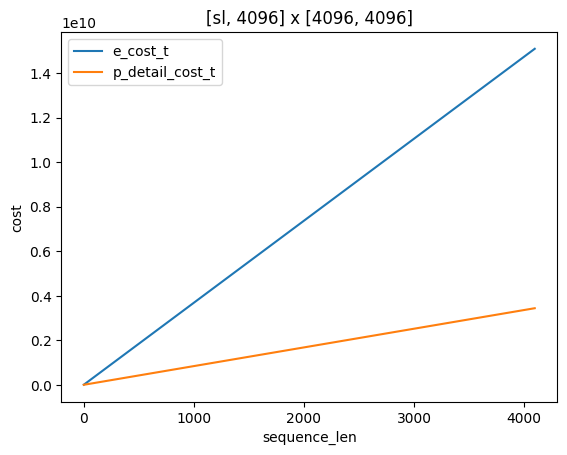

In [143]:
measuring = 'cost'
plt.figure()
plt.plot(sequence_len, e_cost, label='e_cost_t')
plt.plot(sequence_len, p_cost, label='p_detail_cost_t')

# for idx, val in enumerate(difference):
#     if val < 0:
#         x_intercept = arithmatic_intensity[idx - 1]
#         break

# plt.scatter(x_intercept, 0, color="blue")  # Mark the x-intercept with a red dot

# plt.annotate(
#     f"intensity threshold = {round(x_intercept)}",
#     xy=(x_intercept, 0),
#     xytext=(5, 10),
#     textcoords="offset points",
#     ha="center",
#     color="black",
# )

plt.xlabel("sequence_len")
plt.ylabel(measuring)
plt.title('[sl, 4096] x [4096, 4096]')
# plt.title('[sl,128] x [128, sl]')

plt.legend()
plt.show()

# Arithmatic intensity Calculations

In [25]:
# Energy in pj
# Assume its in SRAM


DRAM_READ = 160
DRAM_WRITE = 160
HBM_READ = 40
HBM_WRITE = 40
SRAM_READ = 12
SRAM_WRITE = 12
LOCAL_READ = 1
LOCAL_WRITE = 1
PHU_MAC = 0.04


DAC_POWER = 3.18
ADC_POWER = 1.6


num_mac = 20
num_float_i = 5
num_float_o = 5




ARI = num_mac / (num_float_i + num_float_o)


S_p = 0.04
S_e = 2
T_p_i = SRAM_READ + LOCAL_WRITE + LOCAL_READ + DAC_POWER
T_p_o = ADC_POWER + LOCAL_WRITE + LOCAL_READ + SRAM_WRITE
T_e_i = SRAM_READ + LOCAL_WRITE + LOCAL_READ
T_e_o = LOCAL_WRITE + LOCAL_READ + SRAM_WRITE


savings_comput = S_e - S_p
savings_transfer = (T_e_i + T_e_o) - (T_p_i + T_p_o)


compute_to_transfer = abs(savings_comput / savings_transfer)

print(f'{compute_to_transfer} = compute gain/ transfer loss ')
print(f'ARI:{ARI} = macs/transfer')

if ARI > 1/compute_to_transfer:
    print('PHU')
else:
    print('CPU')

0.410041841004184 = compute gain/ transfer loss 
ARI:2.0 = macs/transfer
CPU
